<a href="https://colab.research.google.com/github/CorentinMAG/NLP/blob/main/POS_TAGGING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
URL = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

# Assignment 3 : Sequence labelling with RNNs
In this assignement we will ask you to perform POS tagging.

You are asked to follow these steps:
*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the model
*   Evaluate your best model
*   Analyze the errors of your model

**Corpora**:
Ignore the numeric value in the third column, use only the words/symbols and its label.
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip 

**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Baseline**: two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top.

**Modifications**: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and using a CRF in addition to the LSTM. Each of this change must be done by itself (don't mix these modifications).

**Training and Experiments**: all the experiments must involve only the training and validation sets.

**Evaluation**: in the end, only the best model of your choice must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech (without considering punctuation classes).

**Error Analysis** (optional) : analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

**Report**: You are asked to deliver a small report of about 4-5 lines in the .txt file that sums up your findings.

In [ ]:
# usefuls import
import pandas as pd
import numpy as np
import os
from urllib import request
from zipfile import ZipFile
import shutil
import re
import gensim
import gensim.downloader as gloader
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional,TimeDistributed, Dropout
from keras.models import Model
import matplotlib.pyplot as plt
from copy import deepcopy
import tensorflow as tf
from sklearn.metrics import f1_score

# Download the dataset

In [ ]:
def download(url,folder=None):
    _curr = '/content/'
    
    if folder is None:
        _folder = os.path.join(_curr,"Datasets")
    else:
        _folder = os.path.join(_curr,folder)
    
    if not os.path.exists(_folder):
        os.makedirs(_folder)
    
    _download = os.path.join(_folder,"dataset.zip")
        
    if not os.path.exists(_download):
        print('Downloading dataset...')
        request.urlretrieve(url,_download)
        with ZipFile(_download) as f:
            f.extractall(_folder)
    _dataset = os.path.join(_folder,"dependency_treebank")
    print('Done !')
    return _dataset

def split_files(corpora,train_length,test_length,validation_length):
    _folder = corpora
    if len(os.listdir(_folder)) != 3:
        train_folder = os.path.join(_folder,"train")
        test_folder = os.path.join(_folder,"test")
        validation_folder = os.path.join(_folder,"validation")
        os.makedirs(train_folder)
        os.makedirs(test_folder)
        os.makedirs(validation_folder)
        for f in os.listdir(_folder):
            file_path = os.path.join(_folder,f)
            if os.path.isfile(file_path):
                number = int(f.split('.')[0].split('_')[1])
                if train_length[0] <= number <= train_length[1]:
                    shutil.move(file_path,train_folder)
                if test_length[0] <= number <= test_length[1]:
                    shutil.move(file_path,test_folder)
                if validation_length[0] <= number <= validation_length[1]:
                    shutil.move(file_path,validation_folder)

In [ ]:
# we download the corpora
path = download(URL)

Done !


Now we have all files in the same folder, we will create a train/valid and test folder 

In [ ]:
split_files(path,[1,100],[151,199],[101,150])

In [ ]:
sorted(os.listdir(path))

['test', 'train', 'validation']

In [ ]:
test_path,train_path,validation_path = [os.path.join(path,x) for x in os.listdir(path)]

Now that we have a better architecture, we can load the data

# Load data

Well now we need to load the data. We will create 3 dataframes for the training/validation and test set.

* Each row in a dataframe represents a file

A dataframe contains 3 columns:
* 1st : sequence of words in the file
* 2nd : the sequence of tag
* 3rd : the id of the file

In [ ]:
def create_dataframe(path):
    _df = pd.DataFrame(columns=['w_sequence','t_sequence','f_id'])
    i = 0
    for file in os.listdir(path):
        _file = os.path.join(path,file)
        f_id = re.findall('\d+',file)[0]
        w_seq = []
        t_seq = []
        with open(_file) as f:
            for row in f:
                if row == '\n':continue
                w = row.split('\t')[0]
                t = row.split('\t')[1]
                w_seq.append(w)
                t_seq.append(t)
        _df.loc[-1] = [w_seq, t_seq,f_id]
        _df.index = _df.index + 1  
        _df = _df.sort_index()
    return _df

In [ ]:
tr_df = create_dataframe(train_path)
valid_df = create_dataframe(validation_path)
ts_df = create_dataframe(test_path)

In [ ]:
tr_df.head()

,w_sequence,t_sequence,f_id
0,"[PAPERS, :, Backe, Group, Inc., agreed, to, ac...","[NNS, :, NNP, NNP, NNP, VBD, TO, VB, NNP, NNP,...",0052
1,"[Italian, chemical, giant, Montedison, S.p.A.,...","[JJ, NN, NN, NNP, NNP, ,, IN, PRP$, NNP, NNP, ...",0032
2,"[The, U.S., and, Soviet, Union, are, holding, ...","[DT, NNP, CC, NNP, NNP, VBP, VBG, JJ, NNS, IN,...",0035
3,"[Newsweek, ,, trying, to, keep, pace, with, ri...","[NNP, ,, VBG, TO, VB, NN, IN, JJ, NNP, NN, ,, ...",0012
4,"[The, Treasury, said, it, plans, to, sell, $, ...","[DT, NNP, VBD, PRP, VBZ, TO, VB, $, CD, CD, IN...",0075


In [ ]:
print(f" the training set contains {tr_df.shape[0]} files ")

 the training set contains 100 files 


# Data Visualization

In this step, we will try to know a bit more about our data

## Training dataset

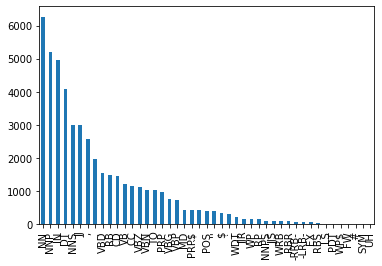

In [ ]:
all_t = pd.Series([x for _list in tr_df['t_sequence'] for x in _list])
all_t.value_counts().plot.bar()

In [ ]:
print("the most represented tokens in the training set :\n")
all_t.value_counts()[:5]

the most represented tokens in the training set :



NN     6270
NNP    5202
IN     4952
DT     4076
NNS    3004
dtype: int64

Below we can see all the POS tokens available.

In [ ]:
pd.unique(all_t)

array(['NNS', ':', 'NNP', 'VBD', 'TO', 'VB', ',', 'WDT', 'VBZ', 'CD',
       'NN', 'CC', 'JJ', 'IN', '$', '.', 'RB', 'VBN', 'DT', 'PRP$', 'VBG',
       'NNPS', 'POS', 'VBP', 'PRP', 'MD', '``', "''", 'JJR', 'WP', 'RP',
       'JJS', '-LRB-', '-RRB-', 'RBR', 'RBS', 'WP$', 'WRB', 'EX', 'PDT',
       'LS', 'UH', '#', 'SYM', 'FW'], dtype=object)

In [ ]:
print(f" we have : {len(pd.unique(all_t))} differents tokens in the training set")

 we have : 45 differents tokens in the training set


In [ ]:
all_w = pd.Series([x for _list in tr_df['w_sequence'] for x in _list])
print(f" there are {len(all_w)} words in the training dataset ")

 there are 47356 words in the training dataset 


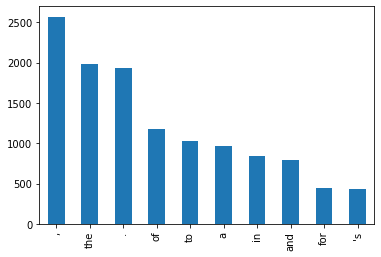

In [ ]:
all_w.value_counts()[:10].plot.bar()

Above we have the most representated words in the training dataset.
We can see that punctuation mark (, and .) are highly represented as well as common english stopwords.

## Validation dataset

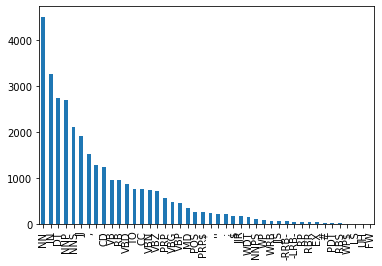

In [ ]:
allv_t = pd.Series([x for _list in valid_df['t_sequence'] for x in _list])
allv_t.value_counts().plot.bar()

In [ ]:
print(f" we have : {len(pd.unique(all_t))} differents tokens in the validation dataset")

 we have : 45 differents tokens in the validation dataset


In [ ]:
all_lw = pd.Series([x for _list in valid_df['w_sequence'] for x in _list])
print(f"there are {len(all_lw)} words in the validation dataset")

there are 31183 words in the validation dataset


## Test dataset

In [ ]:
all_tt = pd.Series([x for _list in ts_df['t_sequence'] for x in _list])
print(f" we have : {len(pd.unique(all_tt))} differents tokens in the test dataset")

 we have : 40 differents tokens in the test dataset


In [ ]:
print(f" there are {len(all_tt)} words in the test dataset")

 there are 15545 words in the test dataset


**The distribution of words and tokens is quite the same in all datasets**

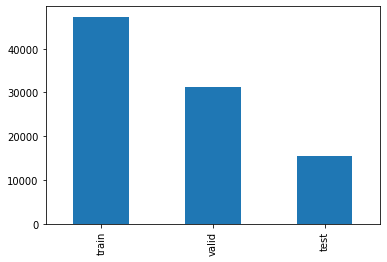

In [ ]:
pd.Series({"train":len(all_w),"valid":len(allv_t),"test":len(all_tt)}).plot.bar()

Above we can see the number of words in each dataset

Now that we have all our data, we will need to preprocess them.

Indeed, we will feed a neural network which can only compute numbers. So, we will need to embed our words (it's the most efficient way to represent words) and map these vectors to integer. 

# Preprocessing

The preprocessing part can be split in severals steps:
* download a pre-trained embedding model called Glove
* create a vocabulary from the Glove model
* compute embedding for out of vocabulary words of the training dataset
* update the vocabulary
* repeat the last 2 steps for the validation and test dataset

It's not very rigorous, in a real world case scenario, we will train the model before each vocabulary update. But will do as is for sake of simplicity.

## Download Glove embedding model

In [ ]:
EMBEDDING_SIZE = 300

In [ ]:
def download_glove_embedding(embedding_dimension=50):
  download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
  try:
    emb_model = gloader.load(download_path)
  except ValueError as e:
      print("Glove: 50, 100, 200, 300")
      raise e
  return emb_model

In [ ]:
glove_model = download_glove_embedding(EMBEDDING_SIZE)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
print(f"size of the vocab of the pre-trained model : {len(glove_model.vocab)}")

size of the vocab of the pre-trained model : 400000


## Create a vocabulary from the Glove model

Now that we have a pre-trained model with 400 000 words we can use this model as our bare vocabulary and adding afterwards out of vocabulary words.  
We have also to add a PAD token.

In [ ]:
vocab = deepcopy(glove_model.vocab)

In [ ]:
def update_vocab(vocab,new_vocab):
  vocab.update(new_vocab)

In [ ]:
def compute_oov_embedding(vocabulary,df):
  oov = {}
  vocab = pd.Series([x for _list in df['w_sequence'] for x in _list])
  vocab = vocab.drop_duplicates()
  vocab = vocab.to_list()
  for w in vocab:
    if w not in vocabulary:
      oov[w] = np.random.randn(1,EMBEDDING_SIZE) # we handle oov words by computing a random embedding
  return oov

In [ ]:
training_oov = compute_oov_embedding(vocab,tr_df) # we compute embedding for oov in the training dataset
update_vocab(vocab,training_oov) # we update the vocabulary with new embeddings
validation_oov = compute_oov_embedding(vocab,valid_df)
update_vocab(vocab,validation_oov)
testing_oov = compute_oov_embedding(vocab,ts_df)
update_vocab(vocab,testing_oov)

In [ ]:
print(f" size of the final vocabulary : {len(vocab)}")

 size of the final vocabulary : 403745


Now that we have all words in the vocabulary we need a way to retrieve them by their index 

In [ ]:
def adapt_vocab(vocab):
  word_list = ["PAD"] # we add the PAD token
  for w in vocab:
    word_list.append(w)
  idx_to_word = pd.Series(word_list,index = [i for i in range(len(word_list))])
  idx_to_word = idx_to_word.to_dict()
  word_to_idx = pd.Series(data = [x for x in range(len(idx_to_word))],index=word_list).to_dict()
  return word_list,idx_to_word,word_to_idx

In [ ]:
word_list,idx_to_word,word_to_idx = adapt_vocab(vocab)

We can now map our word with their embedding in the embedding matrix

## Embedding matrix

In [ ]:
def create_embedding_matrix(model,vocab,word_list,idx_to_word,word_to_idx):
  v = len(word_list)
  embedding_matrix = np.zeros((v,EMBEDDING_SIZE))
  for w,i in word_to_idx.items():
    if w == 'PAD': 
      embedding_matrix[i] = np.zeros((1,EMBEDDING_SIZE))
    elif w in model.vocab:
      embedding_matrix[i] = model.get_vector(w)
    else:
      embedding_matrix[i] = vocab[w]
  return embedding_matrix

In [ ]:
embedding_matrix = create_embedding_matrix(glove_model,vocab,word_list,idx_to_word,word_to_idx)

In [ ]:
embedding_matrix.shape

(403746, 300)

## Word Tokenization

We will map each word with the corresponding index

In [ ]:
def tokenization(seq,word_to_idx):
    return np.array([word_to_idx[x] for x in seq])

In [ ]:
# we encode the training set
tr_df['w_encoded'] = tr_df['w_sequence'].apply(lambda x:tokenization(x,word_to_idx))

# and we do the same for the validation set
valid_df['w_encoded'] = valid_df['w_sequence'].apply(lambda x:tokenization(x,word_to_idx))

# and for the test dataset
ts_df['w_encoded'] = ts_df['w_sequence'].apply(lambda x:tokenization(x,word_to_idx))

In [ ]:
tr_df.head()

,w_sequence,t_sequence,f_id,w_encoded
0,"[PAPERS, :, Backe, Group, Inc., agreed, to, ac...","[NNS, :, NNP, NNP, NNP, VBD, TO, VB, NNP, NNP,...",0052,"[400001, 46, 400002, 400003, 400004, 738, 5, 5..."
1,"[Italian, chemical, giant, Montedison, S.p.A.,...","[JJ, NN, NN, NNP, NNP, ,, IN, PRP$, NNP, NNP, ...",0032,"[400019, 2292, 1753, 400020, 400021, 2, 132, 4..."
2,"[The, U.S., and, Soviet, Union, are, holding, ...","[DT, NNP, CC, NNP, NNP, VBP, VBG, JJ, NNS, IN,...",0035,"[400027, 400032, 6, 400033, 400034, 33, 1384, ..."
3,"[Newsweek, ,, trying, to, keep, pace, with, ri...","[NNP, ,, VBG, TO, VB, NN, IN, JJ, NNP, NN, ,, ...",0012,"[400069, 2, 596, 5, 579, 2409, 18, 1746, 40007..."
4,"[The, Treasury, said, it, plans, to, sell, $, ...","[DT, NNP, VBD, PRP, VBZ, TO, VB, $, CD, CD, IN...",0075,"[400027, 400103, 17, 21, 560, 5, 1244, 81, 408..."


We also need to tokenize POS tokens, we know that we have 45 differents tokens.

In [ ]:
def adapt_token(df):
  token = pd.Series([x for _list in df['t_sequence'] for x in _list])
  token = token.drop_duplicates()
  token_list =["PAD"]+ token.to_list() #we add the PAD token
  idx_to_token = pd.Series(token_list,index=[i for i in range(len(token_list))])
  idx_to_token = idx_to_token.to_dict()
  token_to_idx = pd.Series(data = [x for x in range(len(idx_to_token))],index=token_list).to_dict()
  return token_list,idx_to_token,token_to_idx

In [ ]:
token_list,idx_to_token,token_to_idx = adapt_token(tr_df)
len(token_list)

46

In [ ]:
# we encode the training set
tr_df['t_encoded'] = tr_df['t_sequence'].apply(lambda x:tokenization(x,token_to_idx))

# and we do the same for the validation set
valid_df['t_encoded'] = valid_df['t_sequence'].apply(lambda x:tokenization(x,token_to_idx))

# and for the test dataset
ts_df['t_encoded'] = ts_df['t_sequence'].apply(lambda x:tokenization(x,token_to_idx))

In [ ]:
tr_df.head()

,w_sequence,t_sequence,f_id,w_encoded,t_encoded
0,"[PAPERS, :, Backe, Group, Inc., agreed, to, ac...","[NNS, :, NNP, NNP, NNP, VBD, TO, VB, NNP, NNP,...",0052,"[400001, 46, 400002, 400003, 400004, 738, 5, 5...","[1, 2, 3, 3, 3, 4, 5, 6, 3, 3, 3, 7, 8, 9, 10,..."
1,"[Italian, chemical, giant, Montedison, S.p.A.,...","[JJ, NN, NN, NNP, NNP, ,, IN, PRP$, NNP, NNP, ...",0032,"[400019, 2292, 1753, 400020, 400021, 2, 132, 4...","[13, 11, 11, 3, 3, 7, 14, 20, 3, 3, 3, 13, 11,..."
2,"[The, U.S., and, Soviet, Union, are, holding, ...","[DT, NNP, CC, NNP, NNP, VBP, VBG, JJ, NNS, IN,...",0035,"[400027, 400032, 6, 400033, 400034, 33, 1384, ...","[19, 3, 12, 3, 3, 24, 21, 13, 1, 14, 13, 11, 1..."
3,"[Newsweek, ,, trying, to, keep, pace, with, ri...","[NNP, ,, VBG, TO, VB, NN, IN, JJ, NNP, NN, ,, ...",0012,"[400069, 2, 596, 5, 579, 2409, 18, 1746, 40007...","[3, 7, 21, 5, 6, 11, 14, 13, 3, 11, 7, 4, 13, ..."
4,"[The, Treasury, said, it, plans, to, sell, $, ...","[DT, NNP, VBD, PRP, VBZ, TO, VB, $, CD, CD, IN...",0075,"[400027, 400103, 17, 21, 560, 5, 1244, 81, 408...","[19, 3, 4, 25, 9, 5, 6, 15, 10, 10, 14, 1, 12,..."


In [ ]:
print("second sequence : \n")
print(' '.join(tr_df.iloc[1]['w_sequence']))
print()
print("same but encoded : \n")
print(tr_df.iloc[1]['w_encoded'])

second sequence : 

Italian chemical giant Montedison S.p.A. , through its Montedison Acquisition N.V. indirect unit , began its $ 37-a-share tender offer for all the common shares outstanding of Erbamont N.V. , a maker of pharmaceuticals incorporated in the Netherlands . The offer , advertised in today 's editions of The Wall Street Journal , is scheduled to expire at the end of November . Montedison currently owns about 72 % of Erbamont 's common shares outstanding . The offer is being launched pursuant to a previously announced agreement between the companies .

same but encoded : 

[400019   2292   1753 400020 400021      2    132     48 400020 400022
 400023  10432   1208      2    310     48     81 400024   7383    902
     11     65      1    862    545   3536      4 400025 400023      2
      8   2738      4  12109   5173      7      1 400026      3 400027
    902      2  13635      7    374     10   7022      4 400027 400028
 400029 400030      2     15   1040      5  10873   

## Padding

A neural network require to have input that have the same shape and size. In order to do so, we have to pad/truncate sequences to a fixe length.
However, it is not mandatory, we can operate on sequences of different length, but it is convenient to have a fixe length.

First of all, we look for the longest sequence in each dataset to find the correct length all sentences should have.

In [ ]:
len_tr = tr_df['w_sequence'].apply(pd.Series).shape[1]
len_vl = valid_df['w_sequence'].apply(pd.Series).shape[1]
len_ts = ts_df['w_sequence'].apply(pd.Series).shape[1]
print(f"longest sequence of the training set : {len_tr}")
print(f"longest sequence of the validation set : {len_vl}")
print(f"longest sequence of the test set : {len_ts}")

longest sequence of the training set : 2900
longest sequence of the validation set : 4534
longest sequence of the test set : 1492


We will set padding to 1000, because it is a fair compromise between the training/validation dataset.



In [ ]:
# define some usefuls global variables
MAX_SEQ_LENGTH = 1000
VOCABULARY_SIZE = len(word_to_idx) # vocab size 
NB_TOKENS  = len(token_list)  # token 

In [ ]:
def add_padding(seq,pad_token,pad_length,isw=True):
    if seq.shape[0] < pad_length:
        while seq.shape[0] < pad_length:
            seq = np.append(seq,pad_token)
        return seq if isw else np.expand_dims(seq,axis=0)
    elif seq.shape[0] > pad_length:
        while seq.shape[0] > pad_length:
            seq = np.delete(seq,-1)
        return seq if isw else np.expand_dims(seq,axis=0)
    else:
        return seq if isw else np.expand_dims(seq,axis=0)

In [ ]:
# we add_padding to the encoded sequences of the training set
tr_df['w_encoded'] = tr_df['w_encoded'].apply(lambda x:add_padding(x,0,MAX_SEQ_LENGTH,False))
tr_df['t_encoded'] = tr_df['t_encoded'].apply(lambda x:add_padding(x,0,MAX_SEQ_LENGTH))

# and we do the same for the validation set
valid_df['w_encoded'] = valid_df['w_encoded'].apply(lambda x:add_padding(x,0,MAX_SEQ_LENGTH,False))
valid_df['t_encoded'] = valid_df['t_encoded'].apply(lambda x:add_padding(x,0,MAX_SEQ_LENGTH))

# and for the test set
ts_df['w_encoded'] = ts_df['w_encoded'].apply(lambda x:add_padding(x,0,MAX_SEQ_LENGTH,False))
ts_df['t_encoded'] = ts_df['t_encoded'].apply(lambda x:add_padding(x,0,MAX_SEQ_LENGTH))

In [ ]:
tr_df.head()

,w_sequence,t_sequence,f_id,w_encoded,t_encoded
0,"[PAPERS, :, Backe, Group, Inc., agreed, to, ac...","[NNS, :, NNP, NNP, NNP, VBD, TO, VB, NNP, NNP,...",0052,"[[400001, 46, 400002, 400003, 400004, 738, 5, ...","[1, 2, 3, 3, 3, 4, 5, 6, 3, 3, 3, 7, 8, 9, 10,..."
1,"[Italian, chemical, giant, Montedison, S.p.A.,...","[JJ, NN, NN, NNP, NNP, ,, IN, PRP$, NNP, NNP, ...",0032,"[[400019, 2292, 1753, 400020, 400021, 2, 132, ...","[13, 11, 11, 3, 3, 7, 14, 20, 3, 3, 3, 13, 11,..."
2,"[The, U.S., and, Soviet, Union, are, holding, ...","[DT, NNP, CC, NNP, NNP, VBP, VBG, JJ, NNS, IN,...",0035,"[[400027, 400032, 6, 400033, 400034, 33, 1384,...","[19, 3, 12, 3, 3, 24, 21, 13, 1, 14, 13, 11, 1..."
3,"[Newsweek, ,, trying, to, keep, pace, with, ri...","[NNP, ,, VBG, TO, VB, NN, IN, JJ, NNP, NN, ,, ...",0012,"[[400069, 2, 596, 5, 579, 2409, 18, 1746, 4000...","[3, 7, 21, 5, 6, 11, 14, 13, 3, 11, 7, 4, 13, ..."
4,"[The, Treasury, said, it, plans, to, sell, $, ...","[DT, NNP, VBD, PRP, VBZ, TO, VB, $, CD, CD, IN...",0075,"[[400027, 400103, 17, 21, 560, 5, 1244, 81, 40...","[19, 3, 4, 25, 9, 5, 6, 15, 10, 10, 14, 1, 12,..."


In [ ]:
print("second sequence : \n")
print(' '.join(tr_df.iloc[0]['w_sequence']))
print()
print("same but encoded with padding : \n")
print(tr_df.iloc[0]['w_encoded'])

second sequence : 

PAPERS : Backe Group Inc. agreed to acquire Atlantic Publications Inc. , which has 30 community papers and annual sales of $ 7 million . Terms were n't disclosed . Backe is a closely held media firm run by former CBS Inc. President John Backe . TV : Price Communications Corp. completed the sale of four of its TV stations to NTG Inc. for $ 120 million in cash and notes , retaining a 10 % equity stake in the new concern . NTG was formed by Osborn Communications Corp. and Desai Capital .

same but encoded with padding : 

[[400001     46 400002 400003 400004    738      5   5539 400005 400006
  400004      2     43     32    408    502   3271      6    941    527
       4     81    633     94      3 400007     36     71   5434      3
  400002     15      8   2401    258    494   1002    308     22    158
  400008 400004 400009 400010 400002      3 400011     46 400012 400013
  400014   1316      1   1564      4    134      4     48 400011   1733
       5 400015 400004 

Ok now we're almost done. The final step before the neural network part is to one hot encode our POS tokens

In [ ]:
def to_categorical(sequences, nb_tokens):
    _sequences = []
    for t in sequences:
        _s = np.zeros(nb_tokens,dtype=int)
        _s[t] = 1
        _sequences.append(_s)
    return np.expand_dims(np.array(_sequences),axis=0)

In [ ]:
# we one hot encode tokens
tr_df['t_one_hot_encoded'] = tr_df['t_encoded'].apply(lambda x:to_categorical(x,NB_TOKENS))
# and we do the same for the validation set
valid_df['t_one_hot_encoded'] = valid_df['t_encoded'].apply(lambda x:to_categorical(x,NB_TOKENS))

# and the test set
ts_df['t_one_hot_encoded'] = ts_df['t_encoded'].apply(lambda x:to_categorical(x,NB_TOKENS))

In [ ]:
tr_df.head()

,w_sequence,t_sequence,f_id,w_encoded,t_encoded,t_one_hot_encoded
0,"[PAPERS, :, Backe, Group, Inc., agreed, to, ac...","[NNS, :, NNP, NNP, NNP, VBD, TO, VB, NNP, NNP,...",0052,"[[400001, 46, 400002, 400003, 400004, 738, 5, ...","[1, 2, 3, 3, 3, 4, 5, 6, 3, 3, 3, 7, 8, 9, 10,...","[[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,"[Italian, chemical, giant, Montedison, S.p.A.,...","[JJ, NN, NN, NNP, NNP, ,, IN, PRP$, NNP, NNP, ...",0032,"[[400019, 2292, 1753, 400020, 400021, 2, 132, ...","[13, 11, 11, 3, 3, 7, 14, 20, 3, 3, 3, 13, 11,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0..."
2,"[The, U.S., and, Soviet, Union, are, holding, ...","[DT, NNP, CC, NNP, NNP, VBP, VBG, JJ, NNS, IN,...",0035,"[[400027, 400032, 6, 400033, 400034, 33, 1384,...","[19, 3, 12, 3, 3, 24, 21, 13, 1, 14, 13, 11, 1...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,"[Newsweek, ,, trying, to, keep, pace, with, ri...","[NNP, ,, VBG, TO, VB, NN, IN, JJ, NNP, NN, ,, ...",0012,"[[400069, 2, 596, 5, 579, 2409, 18, 1746, 4000...","[3, 7, 21, 5, 6, 11, 14, 13, 3, 11, 7, 4, 13, ...","[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,"[The, Treasury, said, it, plans, to, sell, $, ...","[DT, NNP, VBD, PRP, VBZ, TO, VB, $, CD, CD, IN...",0075,"[[400027, 400103, 17, 21, 560, 5, 1244, 81, 40...","[19, 3, 4, 25, 9, 5, 6, 15, 10, 10, 14, 1, 12,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


Before feed a neural network we have to reshape a bit our data

In [ ]:
def reshape(X):
  return np.concatenate(X.values)

In [ ]:
## training data
X_train = reshape(tr_df['w_encoded'])
Y_train = reshape(tr_df['t_one_hot_encoded'])

## validation data
X_valid = reshape(valid_df['w_encoded'])
Y_valid = reshape(valid_df['t_one_hot_encoded'])

# test data
X_test = reshape(ts_df['w_encoded'])
Y_test = reshape(ts_df['t_one_hot_encoded'])

# Baseline neural network model

We will implement:
* a BILSTM model
* a BIGRU model 
* a double BILSTM model
* LSTM + CRF

## BILSTM

In [ ]:
def nnLSTM(input_dim,output_dim,input_length,embedding,classes,units):
  lstm = Sequential()
  lstm.add(Embedding(input_dim=input_dim, output_dim=output_dim,input_length=input_length,weights=[embedding],trainable=False,mask_zero=True))
  lstm.add(Bidirectional(LSTM(units=units,return_sequences=True)))
  lstm.add(Dropout(0.2))
  lstm.add(TimeDistributed(Dense(units=classes,activation='softmax')))
  lstm.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
  return lstm

In [ ]:
bilstm_model = nnLSTM(VOCABULARY_SIZE,EMBEDDING_SIZE,MAX_SEQ_LENGTH,embedding_matrix,NB_TOKENS,64)

In [ ]:
bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 300)         121123800 
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 128)         186880    
_________________________________________________________________
dropout (Dropout)            (None, 1000, 128)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1000, 46)          5934      
Total params: 121,316,614
Trainable params: 192,814
Non-trainable params: 121,123,800
_________________________________________________________________


In [ ]:
training_bilstm_model = bilstm_model.fit(X_train,Y_train,batch_size=5,epochs=20,validation_data=(X_valid,Y_valid))

Epoch 1/20
20/20 [==============================] - 19s 974ms/step - loss: 1.3367 - acc: 0.1500 - val_loss: 1.4275 - val_acc: 0.2997
Epoch 2/20
20/20 [==============================] - 16s 821ms/step - loss: 1.0271 - acc: 0.3644 - val_loss: 1.1519 - val_acc: 0.4797
Epoch 3/20
20/20 [==============================] - 17s 826ms/step - loss: 0.8130 - acc: 0.5121 - val_loss: 0.9137 - val_acc: 0.5674
Epoch 4/20
20/20 [==============================] - 16s 782ms/step - loss: 0.6441 - acc: 0.6063 - val_loss: 0.7335 - val_acc: 0.6460
Epoch 5/20
20/20 [==============================] - 15s 760ms/step - loss: 0.5214 - acc: 0.6832 - val_loss: 0.6174 - val_acc: 0.7093
Epoch 6/20
20/20 [==============================] - 17s 870ms/step - loss: 0.4418 - acc: 0.7338 - val_loss: 0.5337 - val_acc: 0.7445
Epoch 7/20
20/20 [==============================] - 18s 892ms/step - loss: 0.3828 - acc: 0.7657 - val_loss: 0.4769 - val_acc: 0.7688
Epoch 8/20
20/20 [==============================] - 17s 827ms/step - 

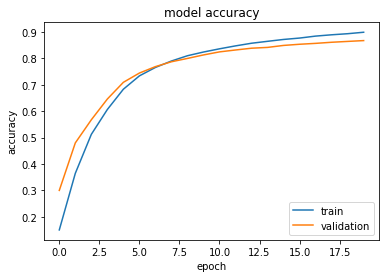

In [ ]:
#visualise training history
plt.plot(training_bilstm_model.history['acc'])
plt.plot(training_bilstm_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()

It seems that after 20 epochs an asymptote is reached (nearby 90% accuracy). So it doesn't make sense to train longer than 20 epochs.  
The validation set has a better acuracy until the 7th epoch and when we train longer, the training set reach a better accuracy.  
**That is a sign that may be the model is overfitting.**

## BIGRU

In [ ]:
def gru(input_dim,output_dim,max_length,embedding_weights,hidden_units,classes):
  gru_model = Sequential()
  gru_model.add(Embedding(input_dim     = input_dim,
                        output_dim    = output_dim,
                        input_length  = max_length,
                        weights       = [embedding_weights],
                        trainable     = False,
                        mask_zero=True
  ))
  gru_model.add(Bidirectional(GRU(hidden_units, return_sequences=True)))
  gru_model.add(Dropout(0.2))
  gru_model.add(TimeDistributed(Dense(classes, activation='softmax')))
  gru_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
  return gru_model

In [ ]:
bigru_model = gru(VOCABULARY_SIZE,EMBEDDING_SIZE,MAX_SEQ_LENGTH,embedding_matrix,64,NB_TOKENS)
bigru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 300)         121123800 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 128)         140544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1000, 46)          5934      
Total params: 121,270,278
Trainable params: 146,478
Non-trainable params: 121,123,800
_________________________________________________________________


In [ ]:
bigru_training_model = bigru_model.fit(X_train,Y_train,batch_size=5,epochs=20,validation_data=(X_valid,Y_valid))

Epoch 1/20
20/20 [==============================] - 15s 730ms/step - loss: 1.2513 - acc: 0.2270 - val_loss: 1.3158 - val_acc: 0.3738
Epoch 2/20
20/20 [==============================] - 13s 648ms/step - loss: 0.8964 - acc: 0.4649 - val_loss: 0.9478 - val_acc: 0.5469
Epoch 3/20
20/20 [==============================] - 13s 650ms/step - loss: 0.6460 - acc: 0.6039 - val_loss: 0.7098 - val_acc: 0.6591
Epoch 4/20
20/20 [==============================] - 15s 734ms/step - loss: 0.4870 - acc: 0.6970 - val_loss: 0.5693 - val_acc: 0.7252
Epoch 5/20
20/20 [==============================] - 14s 693ms/step - loss: 0.3953 - acc: 0.7546 - val_loss: 0.4824 - val_acc: 0.7589
Epoch 6/20
20/20 [==============================] - 13s 647ms/step - loss: 0.3350 - acc: 0.7879 - val_loss: 0.4255 - val_acc: 0.7810
Epoch 7/20
20/20 [==============================] - 13s 649ms/step - loss: 0.2935 - acc: 0.8095 - val_loss: 0.3852 - val_acc: 0.8017
Epoch 8/20
20/20 [==============================] - 13s 651ms/step - 

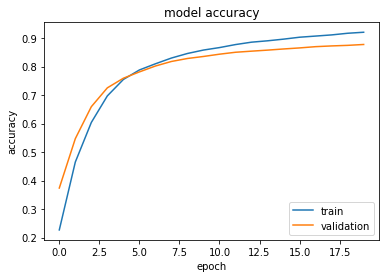

In [ ]:
#visualise training history
plt.plot(bigru_training_model.history['acc'])
plt.plot(bigru_training_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()

As we can see, there are no significant diferences between the BILSTM model and the BIGRU model.

## Double BILSTM

In [ ]:
def doubleBiLSTM(input_dim,output_dim,input_length,embedding,classes,units):
  lstm = Sequential()
  lstm.add(Embedding(input_dim=input_dim, output_dim=output_dim,input_length=input_length,weights=[embedding],trainable=False,mask_zero=True))
  lstm.add(Bidirectional(LSTM(units=units,return_sequences=True)))
  lstm.add(Dropout(0.2))
  lstm.add(Bidirectional(LSTM(units=units,return_sequences=True)))
  lstm.add(Dropout(0.2))
  lstm.add(TimeDistributed(Dense(units=classes,activation='softmax')))
  lstm.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
  return lstm

In [ ]:
double_bilstm_model = doubleBiLSTM(VOCABULARY_SIZE,EMBEDDING_SIZE,MAX_SEQ_LENGTH,embedding_matrix,NB_TOKENS,64)
double_bilstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 300)         121123800 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 128)         186880    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1000, 128)         98816     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1000, 46)          5934      
Total params: 121,415,430
Trainable params: 291,630
Non-trainable params: 121,123,800
__________________________________

In [ ]:
double_bilstm_training_model = double_bilstm_model.fit(X_train,Y_train,batch_size=5,epochs=20,validation_data=(X_valid,Y_valid))

Epoch 1/20
20/20 [==============================] - 36s 2s/step - loss: 1.3192 - acc: 0.1241 - val_loss: 1.5153 - val_acc: 0.2112
Epoch 2/20
20/20 [==============================] - 33s 2s/step - loss: 1.1466 - acc: 0.2085 - val_loss: 1.3663 - val_acc: 0.2923
Epoch 3/20
20/20 [==============================] - 36s 2s/step - loss: 1.0022 - acc: 0.3180 - val_loss: 1.1280 - val_acc: 0.4614
Epoch 4/20
20/20 [==============================] - 32s 2s/step - loss: 0.8024 - acc: 0.4921 - val_loss: 0.8768 - val_acc: 0.5690
Epoch 5/20
20/20 [==============================] - 32s 2s/step - loss: 0.6253 - acc: 0.6051 - val_loss: 0.6949 - val_acc: 0.6527
Epoch 6/20
20/20 [==============================] - 32s 2s/step - loss: 0.5069 - acc: 0.6766 - val_loss: 0.5772 - val_acc: 0.7139
Epoch 7/20
20/20 [==============================] - 34s 2s/step - loss: 0.4246 - acc: 0.7293 - val_loss: 0.4982 - val_acc: 0.7511
Epoch 8/20
20/20 [==============================] - 33s 2s/step - loss: 0.3679 - acc: 0.76

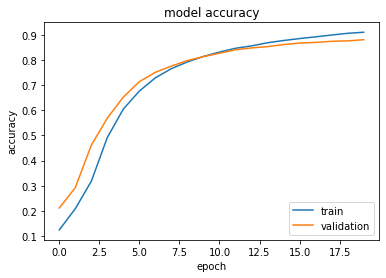

In [ ]:
#visualise training history
plt.plot(double_bilstm_training_model.history['acc'])
plt.plot(double_bilstm_training_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()

The accuracy of this model grows less quickly than previous models. We can see it because the shape of the curve at the begining is smoother.

Futhermore, the point where the accuracy of the training set overcome the accuracy of the validation set is reached at the 9th epoch (two epochs later than the previous models).

## LSTM + CRF

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode

### CRF LAYER CLASS ######
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_matrix],
                        trainable     = False,
                        mask_zero     = True
                    ))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Dense(NB_TOKENS))

crf = CRF(NB_TOKENS, sparse_target=True)
model.add(crf)
model.compile('adam', loss=crf.loss, metrics=[crf.accuracy])
training_crf = model.fit(x=X_train, y=Y_train, epochs=20, batch_size=5, validation_data=(X_valid,Y_valid))

Epoch 1/20
20/20 [==============================] - 30s 2s/step - loss: 1407.7479 - viterbi_accuracy: 0.0763 - val_loss: 3725.2490 - val_viterbi_accuracy: 0.1257
Epoch 2/20
20/20 [==============================] - 25s 1s/step - loss: 1281.9419 - viterbi_accuracy: 0.1506 - val_loss: 3603.6187 - val_viterbi_accuracy: 0.2203
Epoch 3/20
20/20 [==============================] - 25s 1s/step - loss: 1189.4370 - viterbi_accuracy: 0.2154 - val_loss: 3516.1138 - val_viterbi_accuracy: 0.2811
Epoch 4/20
20/20 [==============================] - 25s 1s/step - loss: 1078.7219 - viterbi_accuracy: 0.2792 - val_loss: 3455.2207 - val_viterbi_accuracy: 0.3165
Epoch 5/20
20/20 [==============================] - 25s 1s/step - loss: 987.1557 - viterbi_accuracy: 0.6546 - val_loss: 2904.5232 - val_viterbi_accuracy: 0.8415
Epoch 6/20
20/20 [==============================] - 25s 1s/step - loss: 964.0215 - viterbi_accuracy: 0.8709 - val_loss: 2856.4976 - val_viterbi_accuracy: 0.8643
Epoch 7/20
20/20 [============

It is definitively the best model because the accuracy of the validation set as well as the training set is not limited by an asymptote (or at least this asymptote is above 90%).  

## Evaluation

The model which has the best accuracy on the validation set is the one with LSTM + CRF. So our evaluation will be based on this model.

In [ ]:
def prediction(X,model,df):
  pred = model.predict(X)
  real_pred = []
  pred_int = np.zeros((df.shape[0],MAX_SEQ_LENGTH),dtype=int)
  for i,p in enumerate(pred):
    _len = len(df['t_sequence'][i])
    t_sequence_infered = []
    for j,el in enumerate(p):
        pred_int[i][j] = el.argmax() if j <_len else 0  # we get rid of prediction associated to padding and set to 0
        if j < _len:
          t_sequence_infered.append(idx_to_token[el.argmax()])
    real_pred.append(t_sequence_infered)
  df['t_sequence_infered'] = pd.Series(real_pred)
  df['t_sequence_infered_encoded'] = pd.Series(pred_int.tolist()).apply(lambda x:np.array(x))
  return df

In [ ]:
tr_df = prediction(X_train,model,tr_df)

In [ ]:
tr_df.head()

,w_sequence,t_sequence,f_id,w_encoded,t_encoded,t_one_hot_encoded,t_sequence_infered,t_sequence_infered_encoded
0,"[PAPERS, :, Backe, Group, Inc., agreed, to, ac...","[NNS, :, NNP, NNP, NNP, VBD, TO, VB, NNP, NNP,...",0052,"[[400001, 46, 400002, 400003, 400004, 738, 5, ...","[1, 2, 3, 3, 3, 4, 5, 6, 3, 3, 3, 7, 8, 9, 10,...","[[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[NNP, :, NNP, NNP, NNP, VBD, TO, VB, NNP, NNP,...","[3, 2, 3, 3, 3, 4, 5, 6, 3, 3, 3, 7, 8, 9, 10,..."
1,"[Italian, chemical, giant, Montedison, S.p.A.,...","[JJ, NN, NN, NNP, NNP, ,, IN, PRP$, NNP, NNP, ...",0032,"[[400019, 2292, 1753, 400020, 400021, 2, 132, ...","[13, 11, 11, 3, 3, 7, 14, 20, 3, 3, 3, 13, 11,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0...","[JJ, NN, NN, NNP, NNP, ,, IN, PRP$, NNP, NNP, ...","[13, 11, 11, 3, 3, 7, 14, 20, 3, 3, 3, 13, 11,..."
2,"[The, U.S., and, Soviet, Union, are, holding, ...","[DT, NNP, CC, NNP, NNP, VBP, VBG, JJ, NNS, IN,...",0035,"[[400027, 400032, 6, 400033, 400034, 33, 1384,...","[19, 3, 12, 3, 3, 24, 21, 13, 1, 14, 13, 11, 1...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[DT, NNP, CC, NNP, NNP, VBP, VBG, JJ, NNS, IN,...","[19, 3, 12, 3, 3, 24, 21, 13, 1, 14, 13, 11, 1..."
3,"[Newsweek, ,, trying, to, keep, pace, with, ri...","[NNP, ,, VBG, TO, VB, NN, IN, JJ, NNP, NN, ,, ...",0012,"[[400069, 2, 596, 5, 579, 2409, 18, 1746, 4000...","[3, 7, 21, 5, 6, 11, 14, 13, 3, 11, 7, 4, 13, ...","[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[NNP, ,, VBG, TO, VB, VB, IN, JJ, NNP, NN, ,, ...","[3, 7, 21, 5, 6, 6, 14, 13, 3, 11, 7, 4, 13, 1..."
4,"[The, Treasury, said, it, plans, to, sell, $, ...","[DT, NNP, VBD, PRP, VBZ, TO, VB, $, CD, CD, IN...",0075,"[[400027, 400103, 17, 21, 560, 5, 1244, 81, 40...","[19, 3, 4, 25, 9, 5, 6, 15, 10, 10, 14, 1, 12,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[DT, NNP, VBD, PRP, VBZ, TO, VB, $, CD, CD, IN...","[19, 3, 4, 25, 9, 5, 6, 15, 10, 10, 14, 1, 12,..."


OK now it's the time to compute the F1-score  
I will compute a F1 score for each sequence, and make an average.  
I will also compute a single f1-score on the whole dataset and then compare both.

In [ ]:
def compute_score(df,name):
  x=[]
  for i in range(df.shape[0]):
    f = f1_score(tr_df['t_encoded'][i],tr_df['t_sequence_infered_encoded'][i],average='macro')
    x.append(f)
  df[name] = pd.Series(x)
  return df

In [ ]:
tr_df = compute_score(tr_df,'f1_score_training')

In [ ]:
tr_df.head()

,w_sequence,t_sequence,f_id,w_encoded,t_encoded,t_one_hot_encoded,t_sequence_infered,t_sequence_infered_encoded,f1_score_training
0,"[PAPERS, :, Backe, Group, Inc., agreed, to, ac...","[NNS, :, NNP, NNP, NNP, VBD, TO, VB, NNP, NNP,...",0052,"[[400001, 46, 400002, 400003, 400004, 738, 5, ...","[1, 2, 3, 3, 3, 4, 5, 6, 3, 3, 3, 7, 8, 9, 10,...","[[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[NNP, :, NNP, NNP, NNP, VBD, TO, VB, NNP, NNP,...","[3, 2, 3, 3, 3, 4, 5, 6, 3, 3, 3, 7, 8, 9, 10,...",0.980831
1,"[Italian, chemical, giant, Montedison, S.p.A.,...","[JJ, NN, NN, NNP, NNP, ,, IN, PRP$, NNP, NNP, ...",0032,"[[400019, 2292, 1753, 400020, 400021, 2, 132, ...","[13, 11, 11, 3, 3, 7, 14, 20, 3, 3, 3, 13, 11,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0...","[JJ, NN, NN, NNP, NNP, ,, IN, PRP$, NNP, NNP, ...","[13, 11, 11, 3, 3, 7, 14, 20, 3, 3, 3, 13, 11,...",0.753408
2,"[The, U.S., and, Soviet, Union, are, holding, ...","[DT, NNP, CC, NNP, NNP, VBP, VBG, JJ, NNS, IN,...",0035,"[[400027, 400032, 6, 400033, 400034, 33, 1384,...","[19, 3, 12, 3, 3, 24, 21, 13, 1, 14, 13, 11, 1...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[DT, NNP, CC, NNP, NNP, VBP, VBG, JJ, NNS, IN,...","[19, 3, 12, 3, 3, 24, 21, 13, 1, 14, 13, 11, 1...",0.867254
3,"[Newsweek, ,, trying, to, keep, pace, with, ri...","[NNP, ,, VBG, TO, VB, NN, IN, JJ, NNP, NN, ,, ...",0012,"[[400069, 2, 596, 5, 579, 2409, 18, 1746, 4000...","[3, 7, 21, 5, 6, 11, 14, 13, 3, 11, 7, 4, 13, ...","[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[NNP, ,, VBG, TO, VB, VB, IN, JJ, NNP, NN, ,, ...","[3, 7, 21, 5, 6, 6, 14, 13, 3, 11, 7, 4, 13, 1...",0.929421
4,"[The, Treasury, said, it, plans, to, sell, $, ...","[DT, NNP, VBD, PRP, VBZ, TO, VB, $, CD, CD, IN...",0075,"[[400027, 400103, 17, 21, 560, 5, 1244, 81, 40...","[19, 3, 4, 25, 9, 5, 6, 15, 10, 10, 14, 1, 12,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[DT, NNP, VBD, PRP, VBZ, TO, VB, $, CD, CD, IN...","[19, 3, 4, 25, 9, 5, 6, 15, 10, 10, 14, 1, 12,...",0.924484


Let's compute the global f1 score

In [ ]:
print(f" global F1 score by taking the mean of locals f1 score : {tr_df['f1_score_training'].mean()}")

 global F1 score by taking the mean of locals f1 score : 0.8503667487867985


In [ ]:
def global_f1_score(df):
  _X = np.zeros((1,1),dtype=int)
  for el in df['t_encoded'].to_list():
    _X = np.concatenate((_X,el),axis=None)
  _Y = np.zeros((1,1),dtype=int)
  for el in df['t_sequence_infered_encoded'].to_list():
    _Y = np.concatenate((_Y,el),axis=None)
  X = _X[_X!=0]
  Y = _Y[_Y!=0]
  return f1_score(X,Y,average='macro')

In [ ]:
print(f" global f1 score : {global_f1_score(tr_df)}")

 global f1 score : 0.6980616144027975


The real F1-score is the global one. Indeed, make an average of the locals F1-score isn't a real accurate measure.

Now we can do the same but for the test set

In [ ]:
ts_df = prediction(X_test,model,ts_df)

In [ ]:
ts_df = compute_score(ts_df,'f1_score_testing')

In [ ]:
ts_df.head()

,w_sequence,t_sequence,f_id,w_encoded,t_encoded,t_one_hot_encoded,t_sequence_infered,t_sequence_infered_encoded,f1_score_testing
0,"[ORTEGA, ENDED, a, truce, with, the, Contras, ...","[NNP, VBD, DT, NN, IN, DT, NNPS, CC, VBD, NNS,...",0174,"[[403291, 403292, 8, 4906, 18, 1, 403293, 6, 1...","[3, 4, 19, 11, 14, 19, 22, 12, 4, 1, 4, 18, 16...","[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[NNS, IN, DT, NN, IN, DT, JJ, CC, VBD, NNS, VB...","[1, 14, 19, 11, 14, 19, 13, 12, 4, 1, 4, 18, 1...",0.980831
1,"[RMS, International, Inc., ,, Hasbrouk, Height...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBG, D...",0167,"[[403338, 400061, 400004, 2, 403339, 401979, 2...","[3, 3, 3, 7, 3, 3, 7, 3, 7, 21, 19, 13, 11, 7,...","[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBG, D...","[3, 3, 3, 7, 3, 3, 7, 3, 7, 21, 19, 13, 11, 7,...",0.753408
2,"[The, U.S., International, Trade, Commission, ...","[DT, NNP, NNP, NNP, NNP, VBD, JJ, NNS, IN, DT,...",0183,"[[400027, 400032, 400061, 400932, 400183, 1102...","[19, 3, 3, 3, 3, 4, 13, 1, 14, 19, 3, 13, 11, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[DT, NNP, NNP, NNP, NNP, VBD, JJ, NNS, IN, DT,...","[19, 3, 3, 3, 3, 4, 13, 1, 14, 19, 3, 3, 11, 1...",0.867254
3,"[Metallgesellschaft, AG, said, it, agreed, to,...","[NNP, NNP, VBD, PRP, VBD, TO, VB, CD, NN, IN, ...",0182,"[[403347, 401736, 17, 21, 738, 5, 5539, 3841, ...","[3, 3, 4, 25, 4, 5, 6, 10, 11, 14, 3, 3, 14, 1...","[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[NNP, NNP, VBD, PRP, VBD, TO, VB, CD, NN, IN, ...","[3, 3, 4, 25, 4, 5, 6, 10, 11, 14, 1, 3, 14, 1...",0.929421
4,"[Dell, Computer, Corp., said, it, cut, prices,...","[NNP, NNP, NNP, VBD, PRP, VBD, NNS, IN, JJ, IN...",0154,"[[402013, 401383, 400014, 17, 21, 612, 469, 14...","[3, 3, 3, 4, 25, 4, 1, 14, 13, 14, 20, 13, 11,...","[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[NNP, NNP, NNP, VBD, PRP, VBD, NNS, IN, NNS, I...","[3, 3, 3, 4, 25, 4, 1, 14, 1, 14, 20, 13, 11, ...",0.924484


In [ ]:
print(f" global F1 score by taking the mean of locals f1 score : {ts_df['f1_score_testing'].mean()}")
print(f" global f1 score : {global_f1_score(ts_df)}")

 global F1 score by taking the mean of locals f1 score : 0.8417042546779606
 global f1 score : 0.7539501892168671


# Conclusion

Best model : LSTM + CRF

|| F1-score training  | F1-score testing
|---|---|---
|average locals f1-score| 85%  | 84%  | 
|global F1-score|  70% |  75% |    

There is a lot of others things we could do to improve this F1-score :
* add more/less dropout and try others regularization techniques
* instead of padding at the end of sequences, add padding at the begining
* instead of one hot encode labels, just tokenize them and use `sparse_categorical_crossentropy`
* train longer
* add more/less hidden units
* try with word2vec or fastext instead of Glove
* try with 100-Glove, 50-Glove, 200-Glove